In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
## Estimation of Fuel Cell System price:
truck_cost = 3E5
fuel_cell_cost = 1E5
rated_power = 275

truck_specific = truck_cost/rated_power
fc_specific = fuel_cell_cost/rated_power

print("Truck cost ",truck_specific, "($/kW)")
print("Cell cost ",fc_specific, "($/kW)")

Truck cost  1090.909090909091 ($/kW)
Cell cost  363.6363636363636 ($/kW)


### Constants

In [3]:
F = 96485 # C / mol
ne_H2 = 2 # mol e / mol H
m_H2 = 2 # g/mol
g_to_kg = 1000
G0 = 237000 # J / mol
H0 = 285000 # J / mol
S0 = 163 # J / mol-K
V_to_eff = 26.8 # conversion factor for hydrogen at STP?

In [4]:
### Model assumptions = = = =
## Comment out the variable functions

#Operating
CAPACITY = 0.2 # Shouldn't be above 0.33 per grid modeling results, and likely less..

# Finances
IRR = 0.10 # fractional rate
INFLATION = 0.019 # fractional rate

# System Durability
replace_rate = 10 # Based on a capacity of 0.3 and a 25,0000 hour life (https://www.hydrogen.energy.gov/pdfs/review20/fc163_james_2020_o.pdf)
voltage_drift = 5E-6 # V/h
stack_replacement = 0.15 # fraction


### Cash flow set up

In [5]:
## Balance of plant
# Reference: https://www.hydrogen.energy.gov/pdfs/review20/fc163_james_2020_o.pdf

## Stack model
nameplate_capacity = 1e4  # 10,000 kW (10 MW)
hours_stored = 1e2
max_year = 20

def system_model(fc_stack_cost, MAXCELLV, SHOWCOSTS=False):

    MINEFFICIENCY = MAXCELLV - voltage_drift * 8760 * CAPACITY * replace_rate
    
    #====Model inputs
    balance_specific_cost = 50 # $/kW
     ##Reference: 2021 DOE Hydrogen and Fuel Cells Program Review Presentation
    balance_system_cost = balance_specific_cost * nameplate_capacity
    
    hydrogen_stored = nameplate_capacity * hours_stored / (33.4 * MINEFFICIENCY) #10,000 kW * 100 hours / (33.4 * EFFICIENCY kWh/kg)
    storage_specific_capital = 72 # $/kg stored https://www.hydrogen.energy.gov/pdfs/review19/st001_ahluwalia_2019_o.pdf
    #storage capital can be lower for salt-caverns, for example
    storage_capital = storage_specific_capital * hydrogen_stored
    
    ## Estimated as ~4X LDV BoP cost
    ## See report: "Mass Production Cost Estimation of Direct H2 PEM Fuel...
    ## ... Cell Systems for Transportation Applications: 2018 Update"
    
    system_cost = fc_stack_cost*nameplate_capacity + storage_capital + balance_system_cost
    #====
    
    
    if SHOWCOSTS:
        print()
        print("Total system cost is ${0:.2f} million".format(system_cost/1e6))
        print("Stack:  ${0:.2f} million".format(fc_stack_cost*nameplate_capacity/1e6))
        print("Storage: ${0:.2f} million".format(storage_capital/1e6))
        print("Mechanical: ${0:.2f} million".format(balance_system_cost/1e6))

    return system_cost

### Calculate LCOH

In [6]:
def NPV_calc(HYDROGEN, ELECTRIC, stack_cost, MAXCELLV, SHOWTABLE = False):
    
   #Scheduled cash flow
    CashFlow = pd.DataFrame({'Years':[],'Stack Life':[],'Inflation Year':[],
                            'Stack Eff':[], 'Hydrogen Sales':[],'Replacement Costs':[],'Operating Costs':[],
                            'Net Cash Flow':[],'Discounted Flow':[]})

    system_cost=system_model(stack_cost, MAXCELLV)
    
    ## Initialize variables
    year = [1]
    stacklife = [0]
    inflationyear = [1]
    stackeff = [0]
    hydrogensales = [0]
    replacement_costs = [0]
    operating_costs = [0]
    net_cash = [-system_cost]
    discounted_cash = [net_cash[-1]/(1+IRR)**year[-1]]

    for x in range(2,max_year+2):
        year.append(x)
        inflationyear.append((1+INFLATION)**x)

        #Hydrogen sales
        hydrogensales.append(ELECTRIC*nameplate_capacity*8760*CAPACITY) # [$/kg] * [kg/h] * [h/year] * percent
        hydrogensales[-1] = hydrogensales[-1]*inflationyear[-1]

        #Stacklife counting
        if stacklife[-1] < replace_rate and year[-1] != max_year: # Don't replace stack in the last year of life
            stacklife.append(stacklife[-1]+1)
        else:
            stacklife.append(1)

        #Maintenance cost are 0.5% system cost per year + stack replacement
        replacement_costs.append(stack_replacement*stack_cost*(stacklife[-1]==replace_rate) + 0.005*system_cost)
        replacement_costs[-1] = replacement_costs[-1]*inflationyear[-1]

        #Stack efficiency is the average of the beginning and end of year efficiency
        stackeff.append(V_to_eff*(MAXCELLV - voltage_drift*8760*CAPACITY*(stacklife[-1]+stacklife[-1]-1) / 2) )

        #Operating costs are assumed to be dominated by electricity prices
        operating_costs.append(HYDROGEN*nameplate_capacity*8760*CAPACITY/stackeff[-1]) # [$/kWh] * [kWh/kg] * [kg/h] * [h/year] * percent
        operating_costs[-1] = operating_costs[-1]*inflationyear[-1]

        #Net cash flow = Sales - replacement - operating costs
        net_cash.append(hydrogensales[-1] - operating_costs[-1] - replacement_costs[-1])

        #Discounted cash flow = net cash flow / (1+IRR)^year
        discounted_cash.append(net_cash[-1]/(1+IRR)**year[-1])

    CashFlow['Years'] = year
    CashFlow['Stack Life'] = stacklife
    CashFlow['Inflation Year'] = inflationyear
    CashFlow['Stack Eff'] = stackeff
    CashFlow['Hydrogen Sales'] = hydrogensales
    CashFlow['Replacement Costs'] = replacement_costs
    CashFlow['Operating Costs'] = operating_costs
    CashFlow['Net Cash Flow'] = net_cash
    CashFlow['Discounted Flow'] = discounted_cash
    
    if SHOWTABLE:
        return CashFlow
    else:
        return sum(CashFlow['Discounted Flow'])


In [7]:
cost_of_hydrogen=3
def LCOE(max_cell_v, stack_cost):
  
    low_price = 0.01
    high_price = 0.25
    low_val = NPV_calc(HYDROGEN=cost_of_hydrogen,ELECTRIC=low_price,stack_cost=stack_cost, MAXCELLV=max_cell_v)
    high_val = NPV_calc(HYDROGEN=cost_of_hydrogen, ELECTRIC=high_price,stack_cost=stack_cost, MAXCELLV=max_cell_v)
    
    slope = (high_price - low_price)/(high_val - low_val)
    
    return high_price - high_val*slope

### Iterate across LCOH vs model assumptions

Iteratively set up model + build NPV function before running LCOH function to calculate LCOH

In [8]:
## Set up a mesh grid for desired variables
Es = np.linspace(0.4,1,25)
Stacks = np.logspace(1,3,25)
XX,YY = np.meshgrid(Es,Stacks) # syntax is columns, rows
rs, cs = np.shape(XX)
Z = np.zeros((rs,cs))

for row in range(0,len(Stacks)):
    for col in range(0,len(Es)):
            E = XX[row,col]
            stack = YY[row,col]
            Z[row,col] = LCOE(max_cell_v = E, stack_cost = stack)

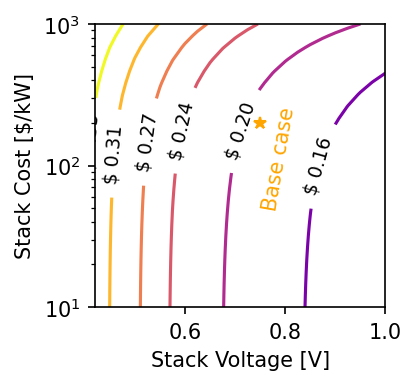

In [9]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
CS = ax.contour(XX, YY, Z, [0.16, 0.20, 0.24, 0.27, 0.31, 0.35], cmap='plasma', vmin=0.10, vmax=0.35)
ax.set_xlabel('Stack Voltage [V]')
ax.set_ylabel('Stack Cost [\$/kW]')
ax.set_yscale('log')
ax.plot(0.75,200,'*',color='orange')
ax.text(0.75,50,'Base case',color='orange', rotation=80)
ax.set_xlim([0.42,1])
ax.clabel(CS, inline=True, fontsize=9, colors='k', fmt='$ %1.2f')
plt.gcf().set_dpi(150)